# Batch Inference Pipeline (SageMaker Pipelines)

- [Overview](#overview)
- [Register model into SageMaker Model Registry](#register-model-into-sagemaker-model-registry)
   1. [Upload Model Artifact to S3 Bucket](#upload-model-artifact-to-s3-bucket)
   2. [Create Model Group](#create-model-group)
   3. [Register Model in Model Registry](#register-model-in-model-registry)
   4. [Approve Model in Model Registry](#approve-model-in-model-registry)
- [Build the pipeline components](#build-the-pipeline-components)
   1. [Import statements and declare parameters and constants](#import-statements-and-declare-parameters-and-constants)
   2. [Generate Data for Inferences](#generate-data-for-inferences)
   3. [Upload Inferences Data to S3 Bucket](#upload-inferences-data-to-s3-bucket)
   4. [Info about the Trained Model (An Approved ModelPackage in SageMaker Model Registry)](#info-about-the-trained-model)
   5. [Define create model step](#define-create-model-step)
   6. [Define Transform Step to Perform Batch Transformation](#define-transform-step-to-perform-batch-transformation)
- [Build and Trigger the pipeline run](#build-and-trigger-the-pipeline-run)

## Overview

The following diagram illustrates the high-level architecture of the ML workflow with the different steps to generate inferences using the trained model artifacts. Here we will use offline inferencing to generate predictions

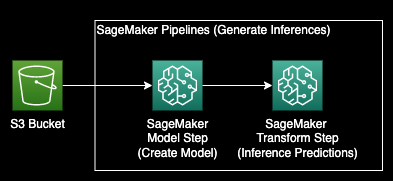

Inference Pipeline consists of the following steps:

1. Create a model in SageMaker using the latest approved model from SageMaker Model Registry.
2. Generate Inferences using the trained model  artifacts.

## Register model into SageMaker Model Registry

If running through this lab independently, go through the optional step of uploading the model artifact [customer-retention-model.tar.gz](https://github.com/aws-samples/amazon-sagemaker-mlops-day/blob/master/model/customer-retention-model.tar.gz) into S3 Bucket, registering the model into SageMaker Model Registry and approving the model.

### Upload Model Artifact to S3 Bucket

In [18]:
!wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/customer-retention-model.tar.gz

--2023-07-07 09:55:31--  https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/customer-retention-model.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12862 (13K) [application/octet-stream]
Saving to: ‘customer-retention-model.tar.gz’

customer-retention- 100%[===================>]  12.56K  --.-KB/s    in 0s      

2023-07-07 09:55:31 (83.4 MB/s) - ‘customer-retention-model.tar.gz’ saved [12862/12862]



In [19]:
import boto3
import sagemaker 

sagemaker_session = sagemaker.session.Session()  
default_bucket = sagemaker_session.default_bucket() 
s3_client = boto3.resource('s3') 
s3_client.Bucket(default_bucket).upload_file("customer-retention-model.tar.gz","model_artifacts/customer-retention-model.tar.gz")

### Create Model Group

In [20]:
import time
import os

model_package_group_name = f"ChurnModelPackageGroupV2"
region = sagemaker_session.boto_region_name
sm_client = boto3.client('sagemaker', region_name=region)
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:866824485776:model-package-group/churnmodelpackagegroupv2


### Register Model in Model Registry

In [21]:
# retrieve the image uri used to train model
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3"
)

# Specify the model source
model_url = f"s3://{default_bucket}/model_artifacts/customer-retention-model.tar.gz"

modelpackage_inference_specification =  {
    "InferenceSpecification": {
      "Containers": [
         {
            "Image": image_uri,
            "ModelDataUrl": model_url
         }
      ],
      "SupportedContentTypes": [ "text/csv" ],
      "SupportedResponseMIMETypes": [ "text/csv" ],
   }
 }

# Alternatively, you can specify the model source like this:
# modelpackage_inference_specification["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]=model_url

create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "Model to detect 3 different types of irises (Setosa, Versicolour, and Virginica)",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:866824485776:model-package/churnmodelpackagegroupv2/1


### Approve Model in Model Registry

## Build the pipeline components

### Step 1: Import statements and declare parameters and constants

In [29]:
import boto3 
import pandas as pd 
import sagemaker 
from sagemaker.workflow.pipeline_context import PipelineSession 

s3_client = boto3.resource('s3') 
pipeline_name = f"sagemaker-mlops-inference-pipeline" 
sagemaker_session = sagemaker.session.Session() 
region = sagemaker_session.boto_region_name 
role = sagemaker.get_execution_role() 
pipeline_session = PipelineSession() 
default_bucket = sagemaker_session.default_bucket() 
model_package_group_name = f"ChurnModelPackageGroup"

In [30]:
from sagemaker.workflow.parameters import ( 
 ParameterInteger, 
 ParameterString, 
 ParameterFloat) 

base_job_prefix = "churn-example"
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
processing_instance_type = ParameterString( name="ProcessingInstanceType", default_value="ml.m5.xlarge")
transform_instance_type = ParameterString(name="TransformInstanceType", default_value="ml.m5.xlarge")
transform_instance_count = ParameterInteger(name="TransformInstanceCount", default_value=1)
batch_data_path = "s3://{}/data/batch/batch.csv".format(default_bucket)
model_approval_status = ParameterString( name="ModelApprovalStatus", default_value="PendingManualApproval")

### Step 2: Generate Data for Inferences

In [31]:
#Run it if tgere 
# !wget https://raw.githubusercontent.com/manifoldailearning/mlops-with-aws-datascientists/main/Section-16-mlops-pipeline/dataset/storedata_total.xlsx
# store_data = pd.read_excel("storedata_total.xlsx") 
# store_data.to_csv("storedata_total.csv")

In [32]:
def preprocess_batch_data(file_path):
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df
    
# convert the store_data file into csv format
store_data = pd.read_excel("storedata_total.xlsx")
store_data.to_csv("storedata_total.csv")

In [40]:
# preprocess batch data and save into the data folder
batch_data = preprocess_batch_data("storedata_total.csv")
batch_data.pop("retained")
batch_sample = batch_data.sample(frac=0.2)
pd.DataFrame(batch_sample).to_csv("batch.csv",header=False,index=False)

### Step 3: Upload Inferences Data to S3 Bucket

In [34]:
s3_client.Bucket(default_bucket).upload_file("batch.csv","data/batch/batch.csv")

### Step 4:  Info about the Trained Model

In [35]:
model_package_group_name

'ChurnModelPackageGroup'

In [36]:
sm_client = boto3.client("sagemaker") 

# get a list of approved model packages from the model package group you specified earlier
approved_model_packages = sm_client.list_model_packages(
      ModelApprovalStatus='Approved',
      ModelPackageGroupName=model_package_group_name,
      SortBy='CreationTime',
      SortOrder='Descending'
  )

# find the latest approved model package
try:
    latest_approved_model_package_arn = approved_model_packages['ModelPackageSummaryList'][0]['ModelPackageArn']
except Exception as e:
    print("Failed to retrieve an approved model package:", e)
    
print(latest_approved_model_package_arn) 

 # retrieve required information about the model
latest_approved_model_package_descr =  sm_client.describe_model_package(ModelPackageName = latest_approved_model_package_arn)

# model artifact uri (tar.gz file)
model_artifact_uri = latest_approved_model_package_descr['InferenceSpecification']['Containers'][0]['ModelDataUrl']
# sagemaker image in ecr
image_uri = latest_approved_model_package_descr['InferenceSpecification']['Containers'][0]['Image']

arn:aws:sagemaker:us-east-1:866824485776:model-package/churnmodelpackagegroup/2


### Step 5: Define create model step

In [37]:
from sagemaker import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

model = Model(
image_uri=image_uri,
model_data=model_artifact_uri,
sagemaker_session=pipeline_session,
role=role
)

step_create_model = ModelStep(
name="ChurnCreateModel",
step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

### Step 6: Define Transform Step to Perform Batch Transformation

In [38]:
from sagemaker.transformer import Transformer
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep

transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{default_bucket}/ChurnTransform",
    sagemaker_session=pipeline_session
)
                                 
step_transform = TransformStep(
    name="ChurnTransform", 
    step_args=transformer.transform(
                    data=batch_data_path,
                    content_type="text/csv"
                 )
)

## Build and Trigger the pipeline run

In [42]:
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        transform_instance_type,
        transform_instance_count,
        batch_data,
    ],
    steps=[step_create_model,step_transform],
) 

In [43]:
# Create a new or update existing Pipeline
pipeline.upsert(role_arn=role)
# start Pipeline execution
pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:866824485776:pipeline/sagemaker-mlops-inference-pipeline/execution/70pidlsk40v7', sagemaker_session=<sagemaker.session.Session object at 0x7fc18d5e7150>)